In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
import numpy as np
import pandas as pd
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve , auc
from sklearn.metrics.cluster import fowlkes_mallows_score as gmean
import statistics as stat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
df_original=pd.read_csv('/content/drive/MyDrive/shuttle-c0-vs-c4.csv')
df_original

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
0,49,0,79,0,46,-5,30,32,2,negative
1,41,1,86,3,42,6,45,45,0,negative
2,50,-4,83,0,50,0,33,34,2,negative
3,48,1,81,-1,46,0,33,34,2,negative
4,45,0,86,0,44,-10,41,42,2,negative
...,...,...,...,...,...,...,...,...,...,...
1824,75,0,80,4,-42,0,5,124,120,positive
1825,85,0,88,0,2,-17,3,86,82,positive
1826,81,0,86,0,-40,2,4,127,122,positive
1827,84,0,88,0,-2,-12,3,90,88,positive


In [31]:
df_original["Class"].value_counts()
class_label=df_original['Class']
class_label

0       negative
1       negative
2       negative
3       negative
4       negative
          ...   
1824    positive
1825    positive
1826    positive
1827    positive
1828    positive
Name: Class, Length: 1829, dtype: object

In [32]:
label_encoder = LabelEncoder()
df_original["Class"] = label_encoder.fit_transform(df_original["Class"])
df_original.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
0,49,0,79,0,46,-5,30,32,2,0
1,41,1,86,3,42,6,45,45,0,0
2,50,-4,83,0,50,0,33,34,2,0
3,48,1,81,-1,46,0,33,34,2,0
4,45,0,86,0,44,-10,41,42,2,0


In [33]:
from sklearn.model_selection import StratifiedKFold
kf=StratifiedKFold(n_splits=5)

x_original=df_original.drop(['Class'],axis='columns')
y_original=df_original.Class
x_original

,A1,A2,A3,A4,A5,A6,A7,A8,A9
0,49,0,79,0,46,-5,30,32,2
1,41,1,86,3,42,6,45,45,0
2,50,-4,83,0,50,0,33,34,2
3,48,1,81,-1,46,0,33,34,2
4,45,0,86,0,44,-10,41,42,2
...,...,...,...,...,...,...,...,...,...
1824,75,0,80,4,-42,0,5,124,120
1825,85,0,88,0,2,-17,3,86,82
1826,81,0,86,0,-40,2,4,127,122
1827,84,0,88,0,-2,-12,3,90,88


# ***Differential evolution implementation***

# **5 fold cross validation**

In [34]:
precision_s=[]
f1_s=[]
recall_s=[]
accuracy_s=[]
Auc_s=[]
Gmean_s=[]

precision_k=[]
f1_k=[]
recall_k=[]
accuracy_k=[]
Auc_k=[]
Gmean_k=[]

precision_d=[]
f1_d=[]
recall_d=[]
accuracy_d=[]
Auc_d=[]
Gmean_d=[]


for train_index,test_index in kf.split(x_original,y_original):
  x_train,x_test=x_original.iloc[train_index],x_original.iloc[test_index]
  y_train,y_test=y_original.iloc[train_index],y_original.iloc[test_index]
  frames = [x_train,y_train]
  df= pd.concat(frames,axis=1,ignore_index=True)
  # print(df)
  minor=df[df[df.columns[len(df.columns)-1]]==1]
  # print(minor)
  major=df[df[df.columns[len(df.columns)-1]]==0]
  # print(major)

  minor=minor.drop(df.columns[len(df.columns)-1], axis=1)
  minority=minor.to_numpy()
  diff=major.shape[0]-minor.shape[0]
  r=diff
  loop=diff/minor.shape[0]
  if(diff%minor.shape[0]==0):
      iter=int(diff/minor.shape[0])
  else:
    iter=int(diff/minor.shape[0])+1


  # DE ALGORITHM
  for id in range(r):
    if(diff>0):
      distances = np.linalg.norm(minority - minority[id], axis=1)  #calculating the distances to other instances
      k = 4
      nearest_neighbor_ids = distances.argsort()[:k] #finding 3 nearest neighbours n1,n2 and n3
      n1=minority[nearest_neighbor_ids[1]]
      n2=minority[nearest_neighbor_ids[2]]
      n3=minority[nearest_neighbor_ids[3]]
      f=0.5    #scaling 
      donor_v= n1 + f*(n2-n3)
      donor_v
      d=minor.shape[1]       #dimension of independent variables 
      cr=0.7      #crossover rate
      mut=np.zeros((d,1)).flatten()
      inv_mut=np.zeros((d,1)).flatten()
      for i in range(d):
        rand =random.random()
        if(rand<cr):
          mut[i]=1
          inv_mut[i]=0
        else:
          mut[i]=0;
          inv_mut[i]=1;

      new_minor=(donor_v * mut) + (minority[id]*inv_mut);
      minB=minor.min().to_numpy()
      maxB=minor.max().to_numpy()
      for i in range(d):
        if(new_minor[i]<minB[i]):
          new_minor[i]=minB[i];
        if(new_minor[i]>maxB[i]):
          new_minor[i]=maxB[i];
      minority=np.append(minority,new_minor)
      minority=np.reshape(minority,(-1, minor.shape[1]))
      diff=diff-1


  df_minor = pd.DataFrame(minority, columns =['A1','A2','A3','A4','A5','A6','A7','A8','A9'])
  # print(df_minor)

  dup=[]
  for i in range(df_minor.shape[0]):
    dup.append(1)
  Class=np.array(dup)
  Class=np.reshape(Class,(-1,1))
  df_minor_class=pd.DataFrame(Class,columns=['Class'])
  df_minor['Class']=df_minor_class
  majority=major.to_numpy()
  majority=np.reshape(majority,(-1,major.shape[1]))
  majority
  df_major = pd.DataFrame(majority, columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','Class'])
  balanced_df=pd.concat([df_minor,df_major],axis=0,ignore_index=True)
  # print(balanced_df)
  # break
  x_train=balanced_df.drop(["Class"], axis=1)
  y_train=balanced_df.Class

  model_b_s=SVC()
  model_b_k=KNeighborsClassifier(n_neighbors=3)
  model_b_d=DecisionTreeClassifier(random_state=0)

  model_b_s.fit(x_train,y_train)
  prediction_b_s = model_b_s.predict(x_test)

  model_b_k.fit(x_train,y_train)
  prediction_b_k = model_b_k.predict(x_test)

  model_b_d.fit(x_train,y_train)
  prediction_b_d = model_b_d.predict(x_test)

  precision_s.append(precision_score(y_test,prediction_b_s))
  precision_k.append(precision_score(y_test,prediction_b_k))
  precision_d.append(precision_score(y_test,prediction_b_d))

  recall_s.append(recall_score(y_test,prediction_b_s))
  recall_k.append(recall_score(y_test,prediction_b_k))
  recall_d.append(recall_score(y_test,prediction_b_d))

  f1_s.append(f1_score(y_test,prediction_b_s))
  f1_k.append(f1_score(y_test,prediction_b_k))
  f1_d.append(f1_score(y_test,prediction_b_d))

  accuracy_s.append(accuracy_score(y_test,prediction_b_s))
  accuracy_k.append(accuracy_score(y_test,prediction_b_k))
  accuracy_d.append(accuracy_score(y_test,prediction_b_d))


  s_fpr_b,s_tpr_b,threshold_s_b=roc_curve(y_test,prediction_b_s)
  k_fpr_b,k_tpr_b,threshold_k_b=roc_curve(y_test,prediction_b_k)
  d_fpr_b,d_tpr_b,threshold_d_b=roc_curve(y_test,prediction_b_d)


  Auc_s.append(auc(s_fpr_b,s_tpr_b))
  Auc_k.append(auc(k_fpr_b,k_tpr_b))
  Auc_d.append(auc(d_fpr_b,d_tpr_b))


  Gmean_s.append(gmean(y_test,prediction_b_s))
  Gmean_k.append(gmean(y_test,prediction_b_k))
  Gmean_d.append(gmean(y_test,prediction_b_d))



In [36]:
print("-------SVM--------")
print("Gmean_SVM:",Gmean_s)
print("AUC_SVM:",Auc_s)

print("mean of Gmean_s:",stat.mean(Gmean_s))
print("mean of AUC_s:",stat.mean(Auc_s))

print("standard deviation of Gmean_s:",stat.stdev(Gmean_s))
print("standard deviation of AUC_s:",stat.stdev(Auc_s))

print("\n")
print("-------KNN--------")
print("Gmean_KNN:",Gmean_k)
print("AUC_KNN:",Auc_k)

print("mean of Gmean_k:",stat.mean(Gmean_k))
print("mean of AUC_k:",stat.mean(Auc_k))

print("standard deviation of Gmean_k:",stat.stdev(Gmean_k))
print("standard deviation of AUC_k:",stat.stdev(Auc_k))


print("\n")
print("-------DECISION TREE--------")
print("Gmean_DT:",Gmean_d)
print("AUC_DT:",Auc_d)

print("mean of Gmean_d:",stat.mean(Gmean_d))
print("mean of AUC_d:",stat.mean(Auc_d))

print("standard deviation of Gmean_d:",stat.stdev(Gmean_d))
print("standard deviation of AUC_d:",stat.stdev(Auc_d))



-------SVM--------
Gmean_SVM: [0.996897106282196, 0.9968632009273501, 0.9968632009273501, 0.9968632009273501, 1.0]
AUC_SVM: [0.9791666666666667, 0.998533724340176, 0.998533724340176, 0.998533724340176, 1.0]
mean of Gmean_s: 0.9974973418128493
mean of AUC_s: 0.9949535679374389
standard deviation of Gmean_s: 0.0013991054894070775
standard deviation of AUC_s: 0.008847955807689843


-------KNN--------
Gmean_KNN: [0.996897106282196, 1.0, 1.0, 1.0, 1.0]
AUC_KNN: [0.9791666666666667, 1.0, 1.0, 1.0, 1.0]
mean of Gmean_k: 0.9993794212564392
mean of AUC_k: 0.9958333333333333
standard deviation of Gmean_k: 0.001387656255993374
standard deviation of AUC_k: 0.009316949906249091


-------DECISION TREE--------
Gmean_DT: [1.0, 1.0, 1.0, 1.0, 1.0]
AUC_DT: [1.0, 1.0, 1.0, 1.0, 1.0]
mean of Gmean_d: 1.0
mean of AUC_d: 1.0
standard deviation of Gmean_d: 0.0
standard deviation of AUC_d: 0.0


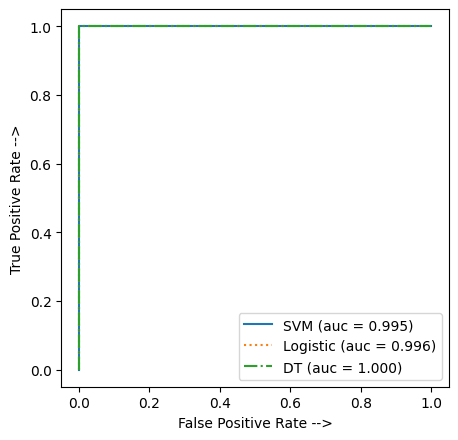

In [44]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(s_fpr_b, s_tpr_b, linestyle='-', label='SVM (auc = %0.3f)' % stat.mean(Auc_s))
plt.plot(k_fpr_b, k_tpr_b, linestyle=':', label='Logistic (auc = %0.3f)' % stat.mean(Auc_k))
plt.plot(d_fpr_b, d_tpr_b, linestyle='dashdot', label='DT (auc = %0.3f)' % stat.mean(Auc_d))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [45]:
df_original

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Class
0,49,0,79,0,46,-5,30,32,2,0
1,41,1,86,3,42,6,45,45,0,0
2,50,-4,83,0,50,0,33,34,2,0
3,48,1,81,-1,46,0,33,34,2,0
4,45,0,86,0,44,-10,41,42,2,0
...,...,...,...,...,...,...,...,...,...,...
1824,75,0,80,4,-42,0,5,124,120,1
1825,85,0,88,0,2,-17,3,86,82,1
1826,81,0,86,0,-40,2,4,127,122,1
1827,84,0,88,0,-2,-12,3,90,88,1


In [48]:
precision_s_imb=[]
f1_s_imb=[]
recall_s_imb=[]
accuracy_s_imb=[]
Auc_s_imb=[]
Gmean_s_imb=[]

precision_k_imb=[]
f1_k_imb=[]
recall_k_imb=[]
accuracy_k_imb=[]
Auc_k_imb=[]
Gmean_k_imb=[]

precision_d_imb=[]
f1_d_imb=[]
recall_d_imb=[]
accuracy_d_imb=[]
Auc_d_imb=[]
Gmean_d_imb=[]

for train_index,test_index in kf.split(x_original,y_original):
    x_train_imb,x_test_imb=x_original.iloc[train_index],x_original.iloc[test_index]
    y_train_imb,y_test_imb=y_original.iloc[train_index],y_original.iloc[test_index]
    model_imb_s=SVC()
    model_imb_k=KNeighborsClassifier(n_neighbors=3)
    model_imb_d=DecisionTreeClassifier(random_state=0)

    model_imb_s.fit(x_train_imb,y_train_imb)
    prediction_imb_s = model_imb_s.predict(x_test_imb)

    model_imb_k.fit(x_train_imb,y_train_imb)
    prediction_imb_k = model_imb_k.predict(x_test_imb)

    model_imb_d.fit(x_train_imb,y_train_imb)
    prediction_imb_d = model_imb_d.predict(x_test_imb)
    precision_s_imb.append(precision_score(y_test_imb,prediction_imb_s))
    precision_k_imb.append(precision_score(y_test_imb,prediction_imb_k))
    precision_d_imb.append(precision_score(y_test_imb,prediction_imb_d))

    recall_s_imb.append(recall_score(y_test_imb,prediction_imb_s))
    recall_k_imb.append(recall_score(y_test_imb,prediction_imb_k))
    recall_d_imb.append(recall_score(y_test_imb,prediction_imb_d))

    f1_s_imb.append(f1_score(y_test_imb,prediction_imb_s))
    f1_k_imb.append(f1_score(y_test_imb,prediction_imb_k))
    f1_d_imb.append(f1_score(y_test_imb,prediction_imb_d))

    accuracy_s_imb.append(accuracy_score(y_test_imb,prediction_imb_s))
    accuracy_k_imb.append(accuracy_score(y_test_imb,prediction_imb_k))
    accuracy_d_imb.append(accuracy_score(y_test_imb,prediction_imb_d))


    s_fpr_imb,s_tpr_imb,threshold_s_imb=roc_curve(y_test_imb,prediction_imb_s)
    k_fpr_imb,k_tpr_imb,threshold_k_imb=roc_curve(y_test_imb,prediction_imb_k)
    d_fpr_imb,d_tpr_imb,threshold_d_imb=roc_curve(y_test_imb,prediction_imb_d)


    Auc_s_imb.append(auc(s_fpr_imb,s_tpr_imb))
    Auc_k_imb.append(auc(k_fpr_imb,k_tpr_imb))
    Auc_d_imb.append(auc(d_fpr_imb,d_tpr_imb))


    Gmean_s_imb.append(gmean(y_test_imb,prediction_imb_s))
    Gmean_k_imb.append(gmean(y_test_imb,prediction_imb_k))
    Gmean_d_imb.append(gmean(y_test_imb,prediction_imb_d))






In [49]:
print("-------SVM--------")
print("Gmean_SVM:",Gmean_s_imb)
print("AUC_SVM:",Auc_s_imb)

print("mean of Gmean_s:",stat.mean(Gmean_s_imb))
print("mean of AUC_s:",stat.mean(Auc_s_imb))

print("standard deviation of Gmean_s:",stat.stdev(Gmean_s_imb))
print("standard deviation of AUC_s:",stat.stdev(Auc_s_imb))

print("\n")
print("-------KNN--------")
print("Gmean_KNN:",Gmean_k_imb)
print("AUC_KNN:",Auc_k_imb)

print("mean of Gmean_k:",stat.mean(Gmean_k_imb))
print("mean of AUC_k:",stat.mean(Auc_k_imb))

print("standard deviation of Gmean_k:",stat.stdev(Gmean_k_imb))
print("standard deviation of AUC_k:",stat.stdev(Auc_k_imb))


print("\n")
print("-------DECISION TREE--------")
print("Gmean_DT:",Gmean_d_imb)
print("AUC_DT:",Auc_d_imb)

print("mean of Gmean_d:",stat.mean(Gmean_d_imb))
print("mean of AUC_d:",stat.mean(Auc_d_imb))

print("standard deviation of Gmean_d:",stat.stdev(Gmean_d_imb))
print("standard deviation of AUC_d:",stat.stdev(Auc_d_imb))



-------SVM--------
Gmean_SVM: [0.996897106282196, 0.9968632009273501, 0.9938017625907885, 0.9968632009273501, 1.0]
AUC_SVM: [0.9791666666666667, 0.998533724340176, 0.96, 0.998533724340176, 1.0]
mean of Gmean_s: 0.996885054145537
mean of AUC_s: 0.9872468230694037
standard deviation of Gmean_s: 0.0021914991939371233
standard deviation of AUC_s: 0.01750078639149893


-------KNN--------
Gmean_KNN: [0.996897106282196, 1.0, 1.0, 1.0, 1.0]
AUC_KNN: [0.9791666666666667, 1.0, 1.0, 1.0, 1.0]
mean of Gmean_k: 0.9993794212564392
mean of AUC_k: 0.9958333333333333
standard deviation of Gmean_k: 0.001387656255993374
standard deviation of AUC_k: 0.009316949906249091


-------DECISION TREE--------
Gmean_DT: [1.0, 1.0, 1.0, 1.0, 1.0]
AUC_DT: [1.0, 1.0, 1.0, 1.0, 1.0]
mean of Gmean_d: 1.0
mean of AUC_d: 1.0
standard deviation of Gmean_d: 0.0
standard deviation of AUC_d: 0.0


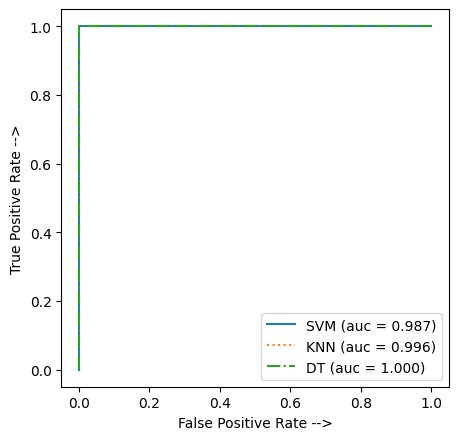

In [50]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(s_fpr_imb, s_tpr_imb, linestyle='-', label='SVM (auc = %0.3f)' % stat.mean(Auc_s_imb))
plt.plot(k_fpr_imb, k_tpr_imb, linestyle=':', label='KNN (auc = %0.3f)' % stat.mean(Auc_k_imb))
plt.plot(d_fpr_imb, d_tpr_imb, linestyle='dashdot', label='DT (auc = %0.3f)' % stat.mean(Auc_d_imb))

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()